In [1]:
from pysheds.grid import Grid

import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

In [2]:
# lat = 32.52726
# lon = -114.79777

lat, lon = 32.49434, -114.81376  # Colorado River at San Luis Rio Colorado
tif = './data/hyd_na_dir_15s.tif'

x = lon
y = lat

start = dt.datetime.now()

grid = Grid.from_raster(tif)
fdir = grid.read_raster(tif)

dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

catchment = grid.catchment(x, y, fdir, dirmap=dirmap, snap='center')

elapsed_time = dt.datetime.now() - start
print(f'Elapsed time: {elapsed_time}')

Elapsed time: 0:00:02.508069


In [3]:
grid.clip_to(catchment)
catch_view = grid.view(catchment, dtype=np.uint8)

In [4]:
import fiona
shapes = grid.polygonize(catch_view)

# Specify schema
schema = {
        'geometry': 'Polygon',
        'properties': {'LABEL': 'float:16'}
}

# Write shapefile
with fiona.open('catchment.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

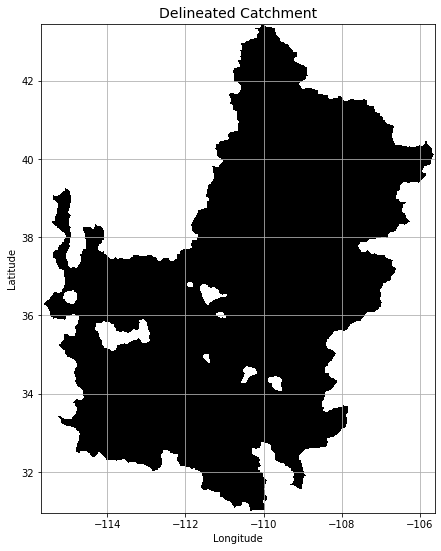

In [6]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(catch_view, catch_view, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

plt.show()